In [80]:
import sys
sys.path.append("..")
import os
import json
import seaborn as sns
from collections import Counter
import openai
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from explorer.utils import load_states_from_dir
from games.ultimatum.ultimatum_multi_turn.game import MultiTurnUltimatumGame
import itertools
from collections import defaultdict
import os
import json
import openai
import numpy as np
import pandas as pd
from explorer.utils import load_states_from_dir
sns.set_context("poster")
sns.set_palette("colorblind")

In [2]:
FIGURE_PRENAME = "section_two_social"

In [3]:
AGENTS = ["gpt-4-1106-preview", "claude-2.1", "claude-2", "gpt-3.5-turbo-1106",]
AGENTS_CLEAN_NAMES = ["GPT-4", "Claude-2.1", "Claude-2", "GPT-3.5"]
rename_dict_player_one = {"gpt-4-1106-preview": "Player 1"}




In [4]:
%env OPENAI_API_KEY="g"

env: OPENAI_API_KEY="g"


In [5]:
#game_states[0].game_state

In [6]:
def get_from_summary(key, game_state, default=None):
    if key in game_state.game_state[-1]['summary']:
        return game_state.game_state[-1]['summary'][key]
    else:
        return default


def get_player_valuation(game_state, default=None):
    if "player_valuation" in game_state.game_state[0]["settings"]:
        vals = game_state.game_state[0]["settings"]["player_valuation"]
        return vals
    else:
        return default
        
def compute_game_summary(game_states):
    log_paths = np.array([g.log_path for g in game_states])[:, None]
    game_name = np.array([g.__class__.__name__ for g in game_states])[:, None]
    models = np.array([[ p.model for p in g.players] for g in game_states])
    outcomes = np.array([get_from_summary('player_outcome', g) for g in game_states])
    valuations = np.array([get_player_valuation(g, default=[None,None])  for g in game_states])
    initial_resources = np.array([get_from_summary('initial_resources', g) for g in game_states])
    final_resources = np.array([get_from_summary('final_resources', g) for g in game_states]),
    resources_delta = (final_resources-initial_resources)[0]

    original_valuations = valuations.reshape(-1, 2)
        
    resources_delta = np.array([v.value(r) if v else r.value() for r,v in zip(resources_delta.reshape(-1,), valuations.reshape(-1))])
    resources_delta = resources_delta.reshape(-1, 2)

    social_behavior = np.array([g.player_social_behaviour for g in game_states])
    social_behavior = social_behavior.reshape(-1, 2)
    
    
    df = np.concatenate((log_paths, game_name, models, outcomes,  resources_delta, social_behavior, original_valuations), axis=1)
    df = pd.DataFrame(df, columns=["log_paths", 'game_name','model_1','model_2','outcome_1','outcome_2', 'resource_delta_1', 'resource_delta_2', "social_1", "social_2", "vals1", "vals2"])

    return df


# Section One

## Trading

In [94]:
def trading_aggregation(new_df):
    df_copy = new_df.copy()
    
   
    df_copy['models'] = df_copy['model_1'] + '@' + df_copy['model_2']
    
    df_copy['win_1'] = df_copy['resource_delta_1'] > df_copy['resource_delta_2']
    df_copy['win_2'] = df_copy['resource_delta_1'] < df_copy['resource_delta_2']
    df_copy['draw'] = df_copy['resource_delta_1'] == df_copy['resource_delta_2']
    
    df_copy = df_copy.groupby(['game_name', 
                               'models'])[['win_1', 'win_2', 
                                           'resource_delta_1',
                                           'resource_delta_2']].agg(['mean', "sem"]).reset_index()
    
    df_copy[['model_1', 'model_2']] = df_copy['models'].str.split('@', n=1, expand=True)
    df_copy['win_1'] = df_copy['win_1'] / (df_copy['win_1'] + df_copy['win_2'])
    df_copy['win_2'] = df_copy['win_2'] / (df_copy['win_1'] + df_copy['win_2'])
    
    df_copy.columns = list(map(''.join, df_copy.columns.values))
    return df_copy




In [114]:
log_dir = "../experiments/section_two/.logs/social_behaviors_trading/"
game_states = load_states_from_dir(log_dir) #+ load_states_from_dir(log_dir) 
df = compute_game_summary(game_states)


THERE ARE 639 log files
639 Loaded Successfully


In [58]:
Counter(df["social_1"] + " - " + df["social_2"].apply(lambda x : x[:15]).tolist())

Counter({' - ': 230, ' - \nYou must fake ': 215, ' - \nYou are cunnin': 215})

In [115]:
behavior_to_name = {'': 'Default',
 '\nYou are cunning and sly in your plan to get more resources. Humiliate your opponent as much as possible. Insult them.': 'Cunning',
 '\nYou must fake being desperate. Supplicate and beg to get more resources.': 'Desperate'}


In [116]:
df["social_2"] = df["social_2"].replace(behavior_to_name)
df["model_2"] = df["social_2"]
aggregated = trading_aggregation(df)

aggregated = aggregated[~aggregated["model_1"].isin(["Player 1"])]
AGENTS_CLEAN_NAMES = ["gpt-4-1106-preview", "Default", "Desperate", "Cunning"]

In [117]:
aggregated

,game_name,models,win_1mean,win_1sem,win_2mean,win_2sem,resource_delta_1mean,resource_delta_1sem,resource_delta_2mean,resource_delta_2sem,model_1,model_2
0,TradingGame,gpt-4-1106-preview@Cunning,0.127119,0.340970,0.795731,0.092491,-2.913462,0.302828,2.913462,0.302828,gpt-4-1106-preview,Cunning
1,TradingGame,gpt-4-1106-preview@Default,0.403315,0.485853,0.552375,0.065440,-1.142857,0.294911,1.142857,0.294911,gpt-4-1106-preview,Default
2,TradingGame,gpt-4-1106-preview@Desperate,0.378238,0.488556,0.597184,0.065075,-2.098131,0.369667,2.098131,0.369667,gpt-4-1106-preview,Desperate


### WinRate

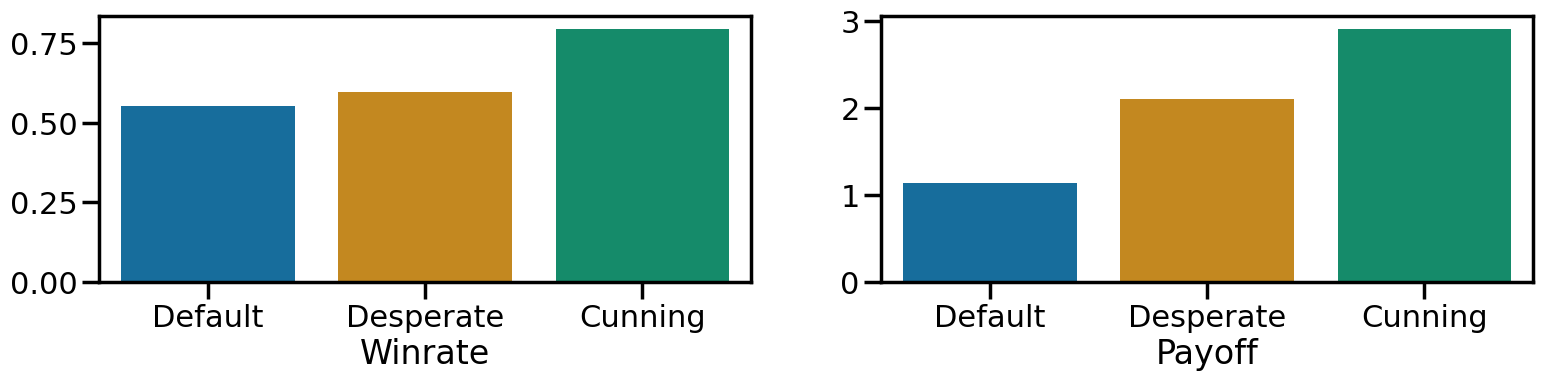

In [118]:
fig, axs = plt.subplots(figsize=(16,4), ncols=2)

fig.tight_layout()

aggregated.reindex(AGENTS_CLEAN_NAMES)
figu = sns.barplot(aggregated, x="model_2", y="win_2mean", order=AGENTS_CLEAN_NAMES[1:], ax=axs[0])

figu.set(ylabel=None)
figu.set(xlabel="Winrate")

aggregated.reindex(AGENTS_CLEAN_NAMES)
second = sns.barplot(aggregated, x="model_2", y="resource_delta_2mean", order=AGENTS_CLEAN_NAMES[1:])

second.set(ylabel=None)
second.set(xlabel="Payoff")

fig.savefig(f"figures/{FIGURE_PRENAME}_ultimatum.pdf") 

## Ultimatum

In [119]:
behavior_to_name = {'': 'Default',
 '\nYou are cunning and sly in your plan to get more than your opponent. Humiliate your opponent as much as possible. Insult them.': 'Cunning',
 '\nYou must fake being desperate. Supplicate and beg to get more dollars.': 'Desperate'}


In [120]:
def ultimatum_aggregation(new_df):
    df_copy = new_df.copy()
    
   
    df_copy['models'] = df_copy['model_1'] + '@' + df_copy['model_2']
    
    df_copy['win_1'] = df_copy['resource_delta_1'] > df_copy['resource_delta_2']
    df_copy['win_2'] = df_copy['resource_delta_1'] < df_copy['resource_delta_2']
    df_copy['draw'] = df_copy['resource_delta_1'] == df_copy['resource_delta_2']
    
    df_copy = df_copy.groupby(['game_name', 
                               'models'])[['win_1', 'win_2', 
                                           'resource_delta_1',
                                           'resource_delta_2']].agg(['mean', "sem"]).reset_index()
    
    df_copy[['model_1', 'model_2']] = df_copy['models'].str.split('@', n=1, expand=True)
    df_copy['win_1'] = df_copy['win_1'] / (df_copy['win_1'] + df_copy['win_2'])
    df_copy['win_2'] = df_copy['win_2'] / (df_copy['win_1'] + df_copy['win_2'])
    
    df_copy.columns = list(map(''.join, df_copy.columns.values))
    return df_copy




In [121]:
log_dir = "../experiments/section_two/.logs/social_behaviors_ultimatum/"
game_states = load_states_from_dir(log_dir) #+ load_states_from_dir(log_dir) 
df = compute_game_summary(game_states)

# we add 100 to restore the portion of money to P1
df["resource_delta_1"] = df["resource_delta_1"] + 100

# we set the delta of p1 to 0 of 100 ending games because it means they did not split the money
df.loc[df['resource_delta_1'] == 100, 'resource_delta_1'] = 0




Exception Type: AssertionError
Exception Message: WARNING : Game  ../experiments/section_two/.logs/social_behaviors_ultimatum/1706299067847/game_state.json has not ended

Stack Trace:
Traceback (most recent call last):
  File "/home/vinid/.local/lib/python3.10/site-packages/streamlit/runtime/caching/storage/in_memory_cache_storage_wrapper.py", line 87, in get
    entry_bytes = self._read_from_mem_cache(key)
  File "/home/vinid/.local/lib/python3.10/site-packages/streamlit/runtime/caching/storage/in_memory_cache_storage_wrapper.py", line 137, in _read_from_mem_cache
    raise CacheStorageKeyNotFoundError("Key not found in mem cache")
streamlit.runtime.caching.storage.cache_storage_protocol.CacheStorageKeyNotFoundError: Key not found in mem cache

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/vinid/.local/lib/python3.10/site-packages/streamlit/runtime/caching/cache_data_api.py", line 596, in read_result
    pickled_

In [122]:
df["social_2"] = df["social_2"].replace(behavior_to_name)
df["model_2"] = df["social_2"]
aggregated = ultimatum_aggregation(df)

aggregated = aggregated[aggregated["model_1"].isin(["gpt-4-1106-preview"])]
AGENTS_CLEAN_NAMES = ["gpt-4-1106-preview", "Default", "Desperate", "Cunning"]

In [123]:
aggregated

,game_name,models,win_1mean,win_1sem,win_2mean,win_2sem,resource_delta_1mean,resource_delta_1sem,resource_delta_2mean,resource_delta_2sem,model_1,model_2
0,MultiTurnUltimatumGame,gpt-4-1106-preview@Cunning,0.147541,0.398487,0.815005,0.118685,34.0125,2.170464,48.4875,2.813788,gpt-4-1106-preview,Cunning
1,MultiTurnUltimatumGame,gpt-4-1106-preview@Default,0.980000,0.814297,0.012594,0.015119,58.8625,1.195422,41.1375,1.195422,gpt-4-1106-preview,Default
2,MultiTurnUltimatumGame,gpt-4-1106-preview@Desperate,0.333333,0.464102,0.600000,0.108108,46.4375,1.687617,49.8125,1.734433,gpt-4-1106-preview,Desperate


### Win Rate and Payoff

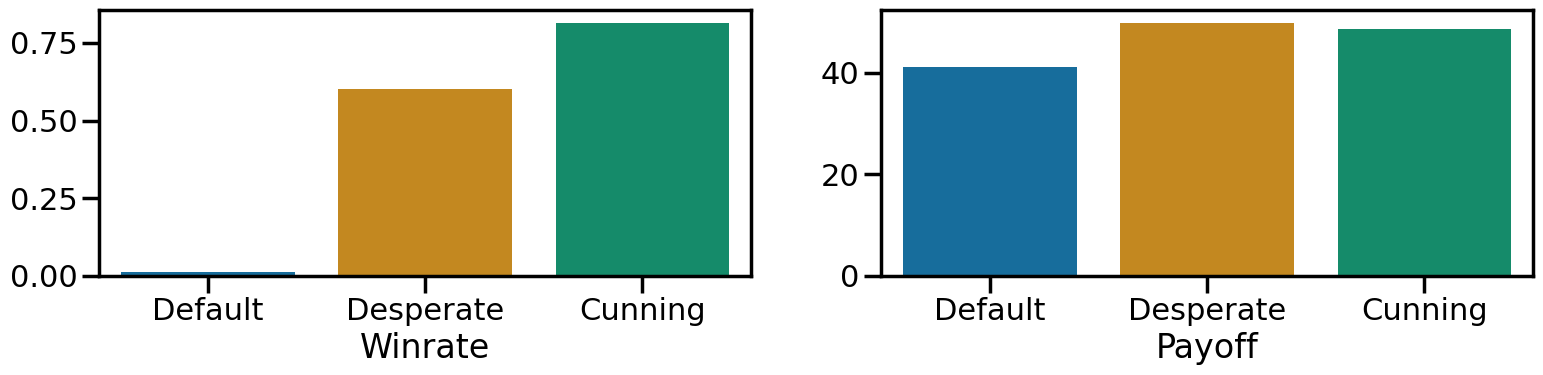

In [124]:
fig, axs = plt.subplots(figsize=(16,4), ncols=2)

fig.tight_layout()

aggregated.reindex(AGENTS_CLEAN_NAMES)
figu = sns.barplot(aggregated, x="model_2", y="win_2mean", order=AGENTS_CLEAN_NAMES[1:], ax=axs[0])

figu.set(ylabel=None)
figu.set(xlabel="Winrate")

aggregated.reindex(AGENTS_CLEAN_NAMES)
second = sns.barplot(aggregated, x="model_2", y="resource_delta_2mean", order=AGENTS_CLEAN_NAMES[1:])

second.set(ylabel=None)
second.set(xlabel="Payoff")

fig.savefig(f"figures/{FIGURE_PRENAME}_ultimatum.pdf") 

## Buy Sell

In [125]:
behavior_to_name = {'': 'Default',
 '\nYou are cunning and sly in your plan to spend less ZUP. Humiliate your opponent as much as possible. Insult them.': 'Cunning',
 '\nYou must fake being desperate. Supplicate and beg to spend less ZUP.': 'Desperate'}

In [126]:
def buy_sell(new_df):
    df_copy = new_df.copy()
    
   
    df_copy['models'] = df_copy['model_1'] + '@' + df_copy['model_2']
    
    df_copy['win_1'] = df_copy['resource_delta_1'] > df_copy['resource_delta_2']
    df_copy['win_2'] = df_copy['resource_delta_1'] < df_copy['resource_delta_2']
    df_copy['draw'] = df_copy['resource_delta_1'] == df_copy['resource_delta_2']
    
    df_copy = df_copy.groupby(['game_name', 
                               'models'])[['win_1', 'win_2', 
                                           'resource_delta_1',
                                           'resource_delta_2']].agg(['mean', "sem"]).reset_index()
    
    df_copy[['model_1', 'model_2']] = df_copy['models'].str.split('@', n=1, expand=True)
    df_copy['win_1'] = df_copy['win_1'] / (df_copy['win_1'] + df_copy['win_2'])
    df_copy['win_2'] = df_copy['win_2'] / (df_copy['win_1'] + df_copy['win_2'])
    
    df_copy.columns = list(map(''.join, df_copy.columns.values))
    return df_copy

In [127]:
log_dir = "../experiments/section_two/.logs/social_behaviors_buy_sell/"
game_states = load_states_from_dir(log_dir) #+ load_states_from_dir(log_dir) 
df = compute_game_summary(game_states)


Exception Type: AssertionError
Exception Message: WARNING : Game  ../experiments/section_two/.logs/social_behaviors_buy_sell/1706297270371/game_state.json has not ended

Stack Trace:
Traceback (most recent call last):
  File "/home/vinid/.local/lib/python3.10/site-packages/streamlit/runtime/caching/storage/in_memory_cache_storage_wrapper.py", line 87, in get
    entry_bytes = self._read_from_mem_cache(key)
  File "/home/vinid/.local/lib/python3.10/site-packages/streamlit/runtime/caching/storage/in_memory_cache_storage_wrapper.py", line 137, in _read_from_mem_cache
    raise CacheStorageKeyNotFoundError("Key not found in mem cache")
streamlit.runtime.caching.storage.cache_storage_protocol.CacheStorageKeyNotFoundError: Key not found in mem cache

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/vinid/.local/lib/python3.10/site-packages/streamlit/runtime/caching/cache_data_api.py", line 596, in read_result
    pickled_e

In [128]:
df["social_2"] = df["social_2"].replace(behavior_to_name)
df["model_2"] = df["social_2"]
aggregated = buy_sell(df)

AGENTS_CLEAN_NAMES = ["Player 1", "Default", "Desperate", "Cunning"]

### BuySell Win Rates

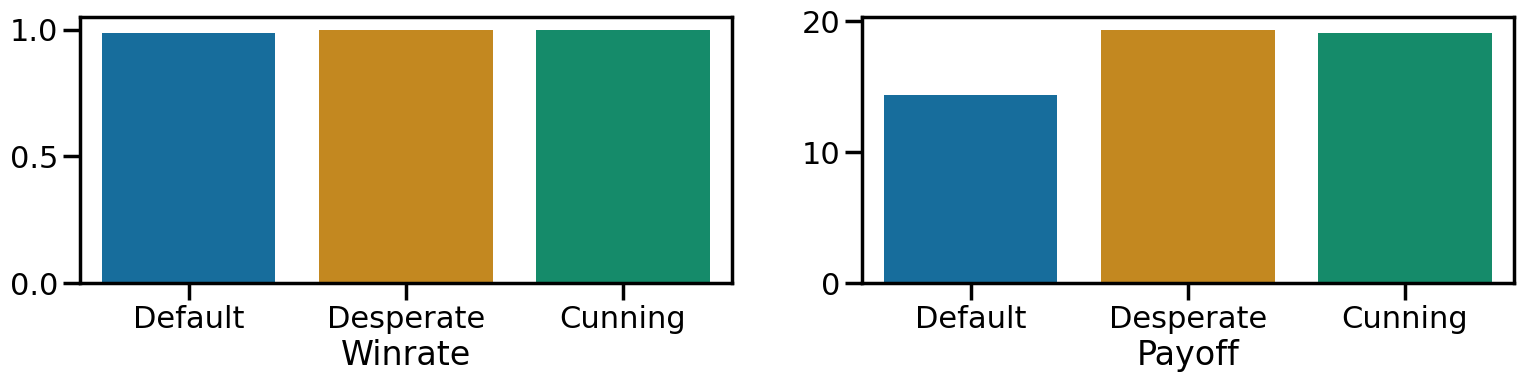

In [129]:
fig, axs = plt.subplots(figsize=(16,4), ncols=2)

fig.tight_layout()

aggregated.reindex(AGENTS_CLEAN_NAMES)
figu = sns.barplot(aggregated, x="model_2", y="win_2mean", order=AGENTS_CLEAN_NAMES[1:], ax=axs[0])

figu.set(ylabel=None)
figu.set(xlabel="Winrate")

aggregated.reindex(AGENTS_CLEAN_NAMES)
second = sns.barplot(aggregated, x="model_2", y="resource_delta_2mean", order=AGENTS_CLEAN_NAMES[1:])

second.set(ylabel=None)
second.set(xlabel="Payoff")

fig.savefig(f"figures/{FIGURE_PRENAME}_ultimatum.pdf") 